In [1]:
import pandas as pd
import os,sys
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
file = 'imputed_data.csv'
data_path = os.path.join('..//data',file)

# read data
df = pd.read_csv(data_path, index_col=False).drop(['Unnamed: 0'], axis=1)
df.reset_index(drop=True, inplace=True)
assert df.isnull().sum().sum() == 0
temp = df.copy()
df.head(5)

CRD PartType  Orient.      X       Y  SPI_VOLUME1  SPI_VOLUME2  SPI_L  \
0  B1    R0402     90.0  31.26  100.11      81.7355      75.6950  61.90   
1  B2    R0402     90.0  31.83  100.11      83.1555      71.5083  63.70   
2  B3    R0402     90.0  32.40  100.11      87.0870      67.2606  72.35   
3  B4    R0402     90.0  32.97  100.11      80.0433      75.8866  63.10   
4  B5    R0402     90.0  33.54  100.11      76.7088      74.0452  69.45   

   SPI_W      PRE_X     PRE_Y  PRE_A     PRE_L      PRE_W     POST_X  \
0   52.0 -19.887293 -1.840963 -1.877 -1.840963  19.887293  -7.440417   
1   47.0 -26.766272  6.898049 -1.449  6.898049  26.766272   5.487133   
2   41.6 -32.058273  8.125244 -3.278  8.125244  32.058273 -19.644203   
3   50.6 -23.437572 -6.195457 -3.337 -6.195457  23.437572 -22.517658   
4   50.0  -5.187286  7.085744 -3.408  7.085744   5.187286 -21.413681   

      POST_Y  POST_A     POST_L     POST_W      Job  Chip_L  Chip_W  \
0  28.108231   1.613  28.108231   7.440417  CENTER    400.0   200.0   
1  22.242701   0.000  22.242701  -5.487133  CENTER    400.0   200.0   
2  12.971593   1.552  12.971593  19.644203  CENTER    400.0   200.0   
3  26.396389   0.000  26.396389  22.517658  CENTER    400.0   200.0   
4  29.193306   3.611  29.193306  21.413681  CENTER    400.0   200.0   

       SPI_R      PRE_R     POST_R  SPI_VOLUME_MEAN  SPI_VOLUME_DIFF  
0  80.843120  19.972320  29.076321         78.71525           6.0405  
1  79.162428  27.640847  22.909526         77.33190          11.6472  
2  83.457070  33.071929  23.540538         77.17380          19.8264  
3  80.882446  24.242596  34.696027         77.96495           4.1567  
4  85.576296   8.781555  36.204901         75.37700           2.6636

In [2]:
# import numpy as np

# filt1 = df.loc[(df['PartType']=='R0603') & (df['Orient.'] == 0)]
# filt2 = df.loc[(df['PartType']=='R0603') & (df['Orient.'] == 90)]
# # assert list(filt1['CRD'])==list(filt2['CRD'])
# x1 = list(filt1['X'])
# y1 = list(filt1['Y'])
# x2 = list(filt2['X'])
# y2 = list(filt2['Y'])

# x = np.unique(list(x1))
# y = np.unique(list(y2))

# a = list(set(y) - set(x))
# b = list(set(x) - set(y))

# a, b

In [3]:
# append PRE-SPI column
xs = df['PRE_L']-df['SPI_L']
ys = df['PRE_W']-df['SPI_W']
vals = [np.linalg.norm((x,y)) for x,y in zip(xs,ys)]
df_to_append = pd.DataFrame({'PRE-SPI': vals})
df_to_append.head()
df_new = df.copy()
df_new.insert(8, 'PRE-SPI', df_to_append)
df_new.drop(columns=['CRD','Job'], inplace=True)
df_new.head()


In [4]:
# make a heatmap of correlation matrix
def get_correlation_map(d, ax):
    # compute the correlation matrix
    corr = d.corr()

    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=bool))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    # cmap='coolwarm'

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, 
                vmax=.3, center=0, square=True, 
                linewidths=.5, 
                cbar=True, cbar_kws={"shrink": .5},
                annot_kws={'size':5},
                robust=True, 
                annot=True, fmt=".1f", ax=ax)
    

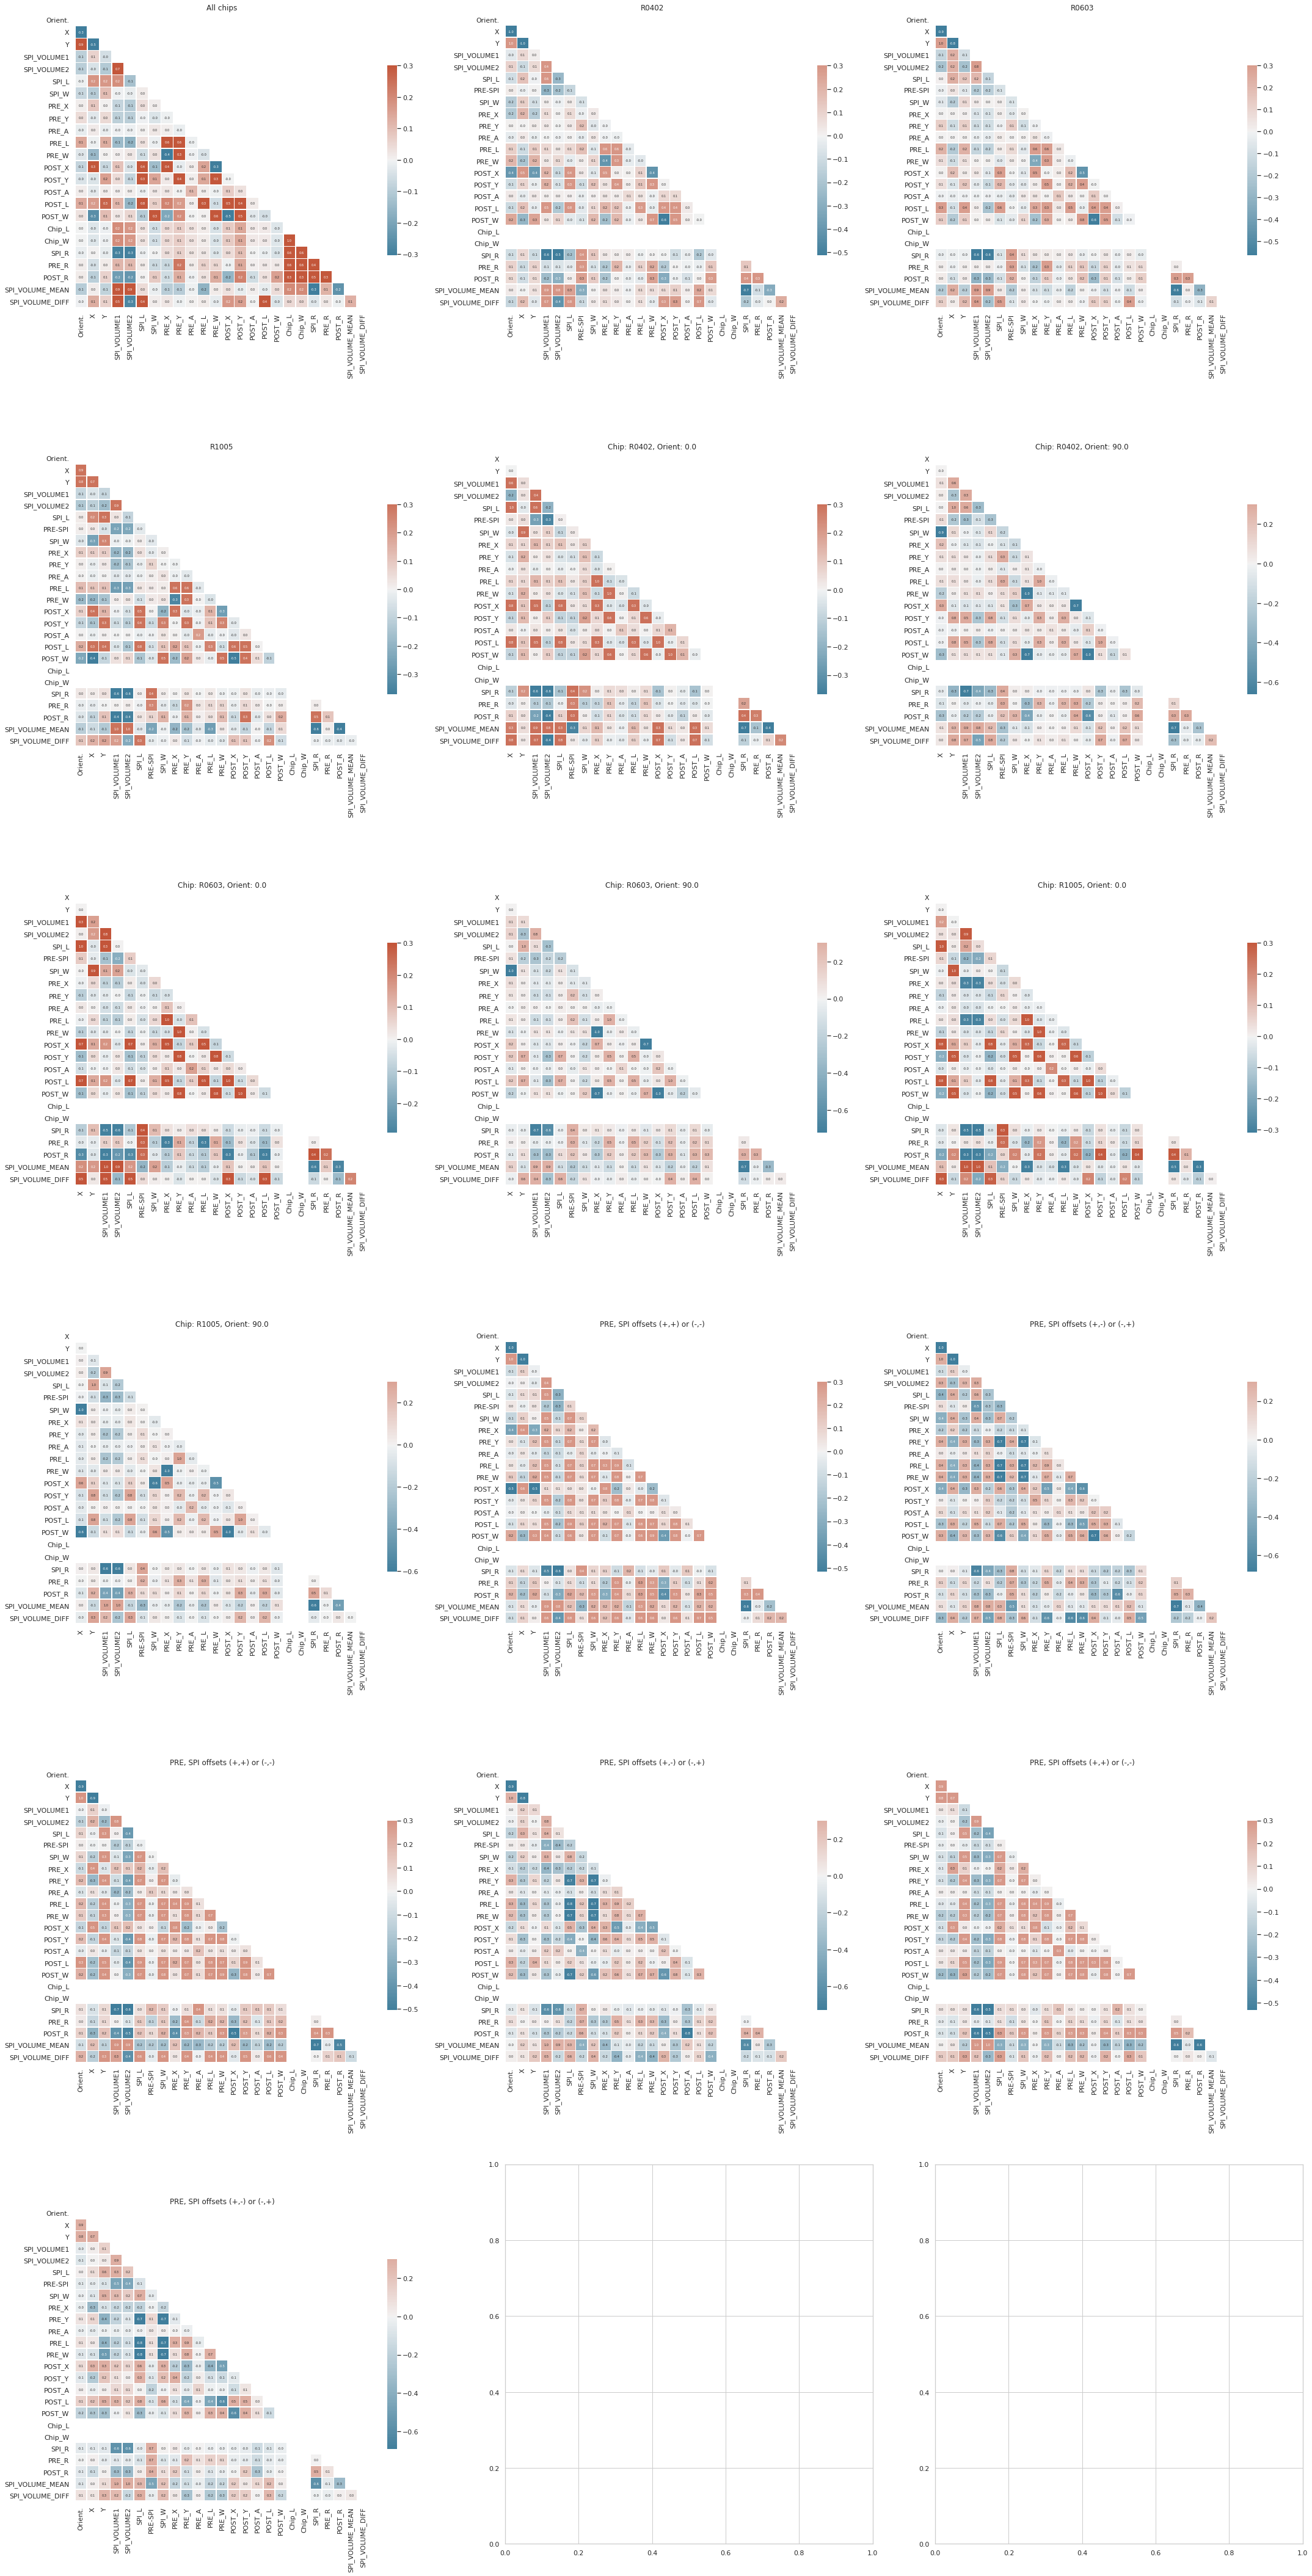

In [8]:
# correlation by conditions
nrows = 6
ncols = 3
figsize = (10*ncols, 10*nrows)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)

sns.set_theme(style="whitegrid")

# case 0: all chips
ax = axes[0,0]
get_correlation_map(df, ax=ax)
ax.set_title('All chips')

# case 1: by chip
dfgroups = df_new.groupby(['PartType'])
df_chip = None
for idx, (name, group) in enumerate(dfgroups):
    group.drop(columns=['PartType'], inplace=True)
    if name == 'R0402':
        ax = axes[0,1]
    elif name == 'R0603':
        ax = axes[0,2]
    elif name == 'R1005':
        ax = axes[1,0]
    df_chip = group
    if ax is not None:
        get_correlation_map(df_chip, ax=ax)
        ax.set_title(name)

# case 2: by chip and orientation
dfgroups = df_new.groupby(['PartType','Orient.'])
df_chip = None
for idx, (name, group) in enumerate(dfgroups):
    group.drop(columns=['PartType','Orient.'], inplace=True)
    ax = None
    if name == ('R0402', 0.0):
        ax = axes[1,1]
    elif name == ('R0402', 90.0):
        ax = axes[1,2]
    elif name == ('R0603', 0.0):
        ax = axes[2,0]
    elif name == ('R0603', 90.0):
        ax = axes[2,1]
    elif name == ('R1005', 0.0):
        ax = axes[2,2]
    elif name == ('R1005', 90.0):
        ax = axes[3,0]
    df_chip = group
    if ax is not None:
        get_correlation_map(df_chip, ax=ax)
        ax.set_title(f'Chip: {name[0]}, Orient: {name[1]}')
        
# case 3: by pre and spi direction pairs
dfgroups = df_new.groupby(['PartType'])
for idx, (name, group) in enumerate(dfgroups):
    ax1, ax2 = None, None
    title = None
    
    pos_pos_condition = (group['PRE_L']>0) & (group['PRE_W']>0) & (group['SPI_L']>0) & (group['SPI_W']>0)
    neg_neg_condition = (group['PRE_L']<0) & (group['PRE_W']<0) & (group['SPI_L']<0) & (group['SPI_W']<0)
    group_same_side = group[pos_pos_condition | neg_neg_condition]
    
    pos_neg_condition = (group['PRE_L']>0) & (group['PRE_W']>0) & (group['SPI_L']<0) & (group['SPI_W']<0)
    neg_pos_condition = (group['PRE_L']<0) & (group['PRE_W']<0) & (group['SPI_L']>0) & (group['SPI_W']>0)
    group_opposite_side = group[pos_neg_condition | neg_pos_condition]
    
    if name == 'R0402':
        ax1 = axes[3,1]
        ax2 = axes[3,2]
    elif name == 'R0603':
        ax1 = axes[4,0]
        ax2 = axes[4,1]
    elif name == 'R1005':
        ax1 = axes[4,2]
        ax2 = axes[5,0]
    if ax1 is not None and ax2 is not None:
        title = 'PRE, SPI offsets (+,+) or (-,-)'
        get_correlation_map(group_same_side, ax=ax1)
        ax1.set_title(title)
        
        title = 'PRE, SPI offsets (+,-) or (-,+)'
        get_correlation_map(group_opposite_side, ax=ax2)
        ax2.set_title(title)
        

plt.tight_layout()
plt.savefig('./correlations.png')
    